In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restaurant-data/restaurants (1).csv


Formulas:
1. Deterministic Utility (W_ig):
   W_ig = β_p * p_i + β_c * c_i + β_d * d_{i,g} + β_r * R_i
   Where:
   - p_i: Price of facility i
   - c_i: Cuisine type (0 or 1)
   - d_{i,g}: Distance between facility i and customer g
   - R_i: Rating of facility i
   - β_p, β_c, β_d, β_r: Coefficients for price, cuisine type, distance, and rating respectively

2. Total Utility (U_ig):
   U_ig = W_ig + ν_{ig}
   Where ν_{ig} ~ Gumbel(0, 1) (random component)

Deterministic Utilities (first 5 facilities):
 [[ -9.77353088 -10.03188007 -11.36009106 ...  -9.02705115 -11.55876791
  -10.69180494]
 [-23.86781936 -22.97002678 -21.93201642 ... -23.96710259 -23.30477683
  -21.92524712]
 [-18.79370851 -21.11865168 -20.43343599 ... -19.70029582 -21.0072171
  -20.32575917]
 [-16.27455744 -15.08579558 -16.48298884 ... -15.10019577 -16.42286872
  -17.51948802]
 [ -4.39313311  -3.49309613  -4.28331137 ...  -5.77973522  -4.61842236
   -4.6703502 ]]

Total Utilities (first 5 facilities for first 5 customer

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


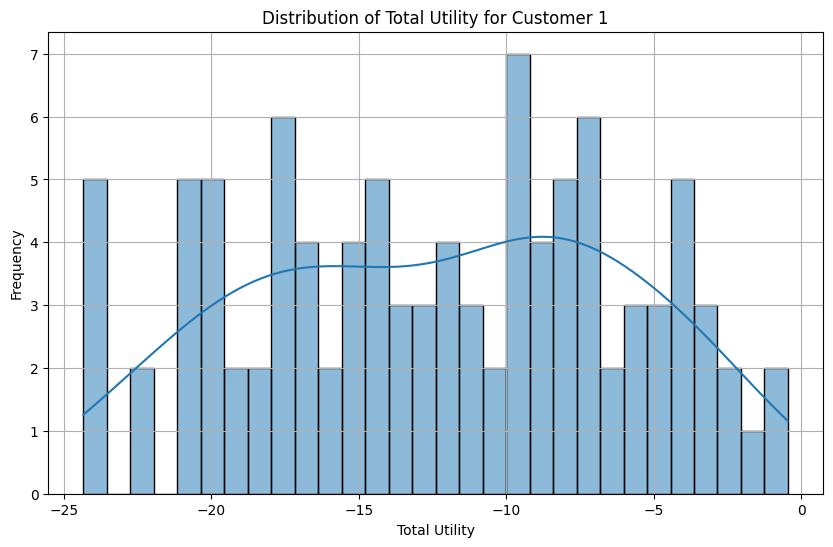

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
num_facilities = 100  # Number of service facilities
num_customers = 1000  # Number of customers
beta_p = -0.5         # Price coefficient
beta_c = 1.0          # Cuisine type coefficient
beta_d = -0.3         # Distance coefficient
beta_r = 0.8          # Rating coefficient

# Generate random data for facilities
prices = np.random.uniform(10, 50, num_facilities)  # Prices between $10 and $50
cuisine_types = np.random.randint(0, 2, num_facilities)  # 0 or 1 for cuisine type
ratings = np.random.uniform(1, 5, num_facilities)  # Ratings between 1 and 5
distances = np.random.uniform(0.5, 10, (num_facilities, num_customers))  # Distances between 0.5 and 10 km

# Create a DataFrame for facilities
facilities = pd.DataFrame({
    'Facility_ID': range(num_facilities),
    'Price': prices,
    'Cuisine_Type': cuisine_types,
    'Rating': ratings
})

# Calculate deterministic utility for each facility
def calculate_utility(facilities, distances):
    utilities = np.zeros((num_facilities, num_customers))
    for i in range(num_facilities):
        W_ig = (beta_p * facilities['Price'][i] +
                beta_c * facilities['Cuisine_Type'][i] +
                beta_d * distances[i] +
                beta_r * facilities['Rating'][i])
        utilities[i, :] = W_ig  # Store utility for all customers
    return utilities

# Calculate deterministic utility for all facilities
deterministic_utilities = calculate_utility(facilities, distances)

# Generate random component from Gumbel distribution
random_component = np.random.gumbel(0, 1, (num_facilities, num_customers))

# Calculate total utility
total_utilities = deterministic_utilities + random_component

# Show results
print("Formulas:")
print("1. Deterministic Utility (W_ig):")
print("   W_ig = β_p * p_i + β_c * c_i + β_d * d_{i,g} + β_r * R_i")
print("   Where:")
print("   - p_i: Price of facility i")
print("   - c_i: Cuisine type (0 or 1)")
print("   - d_{i,g}: Distance between facility i and customer g")
print("   - R_i: Rating of facility i")
print("   - β_p, β_c, β_d, β_r: Coefficients for price, cuisine type, distance, and rating respectively")
print()
print("2. Total Utility (U_ig):")
print("   U_ig = W_ig + ν_{ig}")
print("   Where ν_{ig} ~ Gumbel(0, 1) (random component)")
print()

# Display deterministic utilities for the first 5 facilities
print("Deterministic Utilities (first 5 facilities):\n", deterministic_utilities[:5])
print("\nTotal Utilities (first 5 facilities for first 5 customers):\n", total_utilities[:5, :5])

# Visualize the distribution of total utilities for the first customer
plt.figure(figsize=(10, 6))
sns.histplot(total_utilities[:, 0], bins=30, kde=True)
plt.title('Distribution of Total Utility for Customer 1')
plt.xlabel('Total Utility')
plt.ylabel('Frequency')
plt.grid()
plt.show()

Formulas:
1. Probability of Choosing Facility i (P_ig):
   P_ig = e^{W_{ig}} / Σ_{j ∈ I} e^{W_{jg}}
   Where:
   - P_ig: Probability that a customer at grid point g chooses facility i
   - W_ig: Deterministic utility of facility i for customer at grid point g
   - I: Set of all facilities

2. Market Size in Grid Point g (M_g):
   M_g = (C_g * E_g / E_{max}) * β_z
   Where:
   - M_g: Market size at grid point g
   - C_g: Population density at grid point g
   - E_g: Average income of the population at grid point g
   - E_max: Upper bound on income
   - β_z: Parameter common across all income ranges and grid points

3. Demand at Facility i (D_hat_i):
   D_hat_i = Σ_{g ∈ G} M_g * P_{ig}
   Where:
   - D_hat_i: Demand at facility i
   - G: Set of all grid points

Probabilities of Choosing Each Facility (P_ig):
[[0.16788126 0.30835194 0.2333765 ]
 [0.21005624 0.13928833 0.13119091]
 [0.12233956 0.28335588 0.2047468 ]
 [0.23434383 0.12164561 0.29606201]
 [0.26537912 0.14735824 0.13462378]]

M

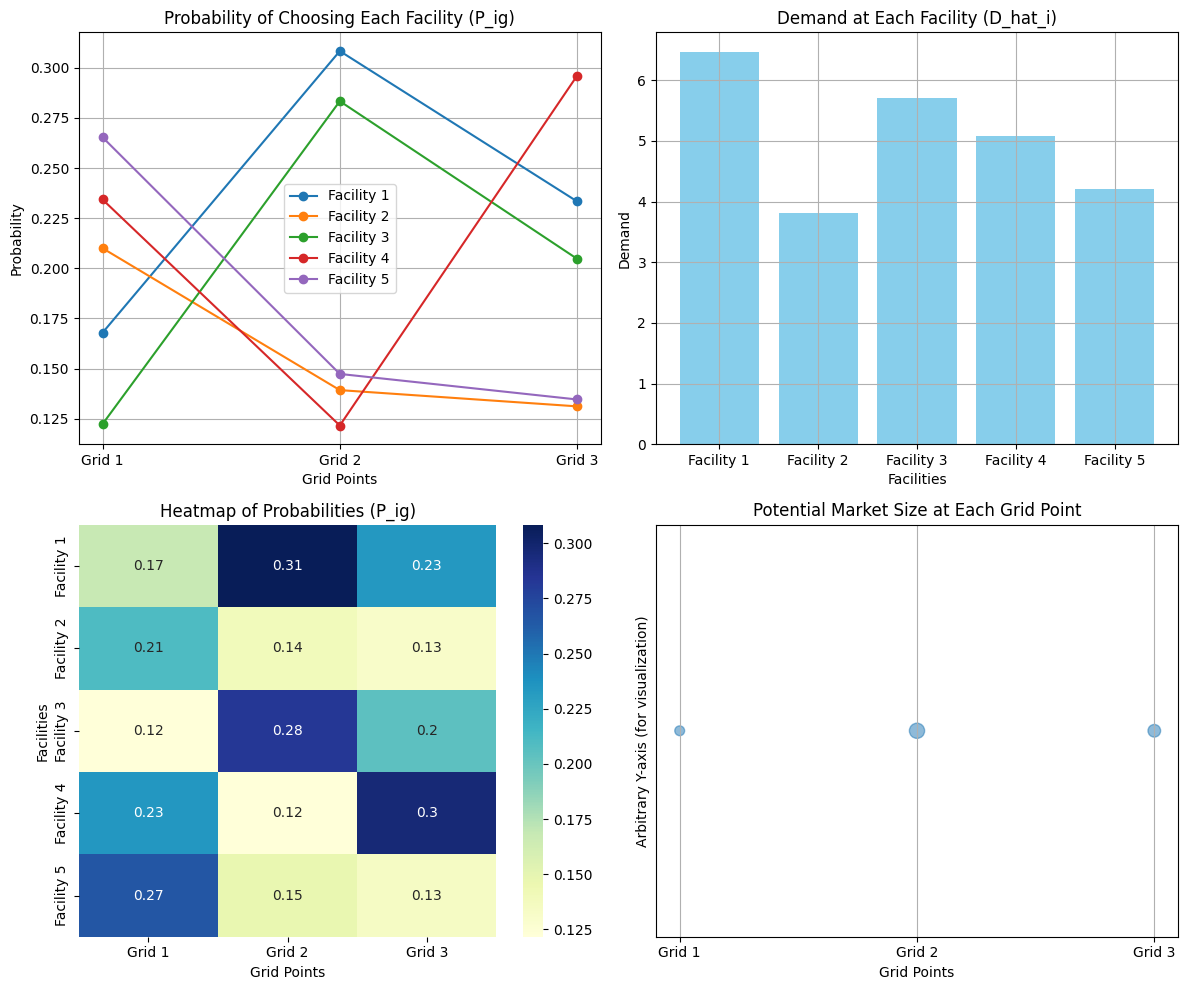

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for heatmaps

# Set random seed for reproducibility
np.random.seed(42)

# Example parameters
num_facilities = 5  # Number of facilities
num_grid_points = 3  # Number of grid points

# Example data
W = np.random.rand(num_facilities, num_grid_points)  # Deterministic utilities
C = np.array([100, 200, 150])  # Population density
E = np.array([50000, 60000, 55000])  # Average income
E_max = 100000  # Upper bound on income
beta_z = 0.1  # Common parameter

# Calculate probabilities and market sizes
def calculate_probabilities_and_demand(W, C, E, E_max, beta_z):
    num_facilities, num_grid_points = W.shape
    P = np.zeros((num_facilities, num_grid_points))  # Probability matrix
    M = (C * E / E_max) * beta_z  # Market size for each grid point
    D_hat = np.zeros(num_facilities)  # Demand for each facility

    for g in range(num_grid_points):
        exp_utilities = np.exp(W[:, g])  # Exponentiated utilities for grid point g
        P[:, g] = exp_utilities / np.sum(exp_utilities)  # Calculate probabilities

    # Calculate demand for each facility
    for i in range(num_facilities):
        D_hat[i] = np.sum(M * P[i, :])  # Demand at facility i

    return P, M, D_hat

# Calculate probabilities and demand
probabilities, market_sizes, demand = calculate_probabilities_and_demand(W, C, E, E_max, beta_z)

# Display results with formulas and term explanations
print("Formulas:")
print("1. Probability of Choosing Facility i (P_ig):")
print("   P_ig = e^{W_{ig}} / Σ_{j ∈ I} e^{W_{jg}}")
print("   Where:")
print("   - P_ig: Probability that a customer at grid point g chooses facility i")
print("   - W_ig: Deterministic utility of facility i for customer at grid point g")
print("   - I: Set of all facilities")
print()
print("2. Market Size in Grid Point g (M_g):")
print("   M_g = (C_g * E_g / E_{max}) * β_z")
print("   Where:")
print("   - M_g: Market size at grid point g")
print("   - C_g: Population density at grid point g")
print("   - E_g: Average income of the population at grid point g")
print("   - E_max: Upper bound on income")
print("   - β_z: Parameter common across all income ranges and grid points")
print()
print("3. Demand at Facility i (D_hat_i):")
print("   D_hat_i = Σ_{g ∈ G} M_g * P_{ig}")
print("   Where:")
print("   - D_hat_i: Demand at facility i")
print("   - G: Set of all grid points")
print()
print("Probabilities of Choosing Each Facility (P_ig):")
print(probabilities)
print("\nMarket Sizes (M_g):")
print(market_sizes)
print("\nDemand at Each Facility (D_hat_i):")
print(demand)

# Plotting the probabilities and demand
plt.figure(figsize=(12, 10))  # Increased figure height to accommodate all plots

# Subplot for probabilities
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
for i in range(num_facilities):
    plt.plot(range(num_grid_points), probabilities[i, :], marker='o', label=f'Facility {i+1}')
plt.title('Probability of Choosing Each Facility (P_ig)')
plt.xlabel('Grid Points')
plt.ylabel('Probability')
plt.xticks(range(num_grid_points), [f'Grid {j+1}' for j in range(num_grid_points)])
plt.legend()
plt.grid()

# Subplot for demand
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
plt.bar(range(num_facilities), demand, color='skyblue')
plt.title('Demand at Each Facility (D_hat_i)')
plt.xlabel('Facilities')
plt.ylabel('Demand')
plt.xticks(range(num_facilities), [f'Facility {i+1}' for i in range(num_facilities)])
plt.grid()

# Heatmap for Probabilities
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, 3rd subplot
sns.heatmap(probabilities, annot=True, cmap='YlGnBu',
            xticklabels=[f'Grid {j+1}' for j in range(num_grid_points)],
            yticklabels=[f'Facility {i+1}' for i in range(num_facilities)])
plt.title('Heatmap of Probabilities (P_ig)')
plt.xlabel('Grid Points')
plt.ylabel('Facilities')

# Bubble chart for potential market size at each grid point
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, 4th subplot
plt.scatter(range(num_grid_points), [1] * num_grid_points, s=market_sizes * 10, alpha=0.5)
plt.title('Potential Market Size at Each Grid Point')
plt.xlabel('Grid Points')
plt.ylabel('Arbitrary Y-axis (for visualization)')
plt.xticks(range(num_grid_points), [f'Grid {j+1}' for j in range(num_grid_points)])
plt.yticks([])  # Remove y-axis ticks
plt.grid(True)

plt.tight_layout()
plt.show()

Formulas:
1. Probability of Choosing Facility i (Pig):
   Pig = e^(Wig) / (1 + Σ(e^(Wig)))
   Where:
   - Pig: Probability that a customer chooses facility i
   - Wig: Deterministic utility of facility i
   - Σ(e^(Wig)): Sum of exponentiated utilities of all facilities

2. Market Size in Grid Point g (Mg):
   Mg = Cg * (Eg / Emax) ^ βz
   Where:
   - Mg: Market size at grid point g
   - Cg: Population density at grid point g
   - Eg: Average income of the population at grid point g
   - Emax: Upper bound on income
   - βz: Parameter common across all income ranges and grid points


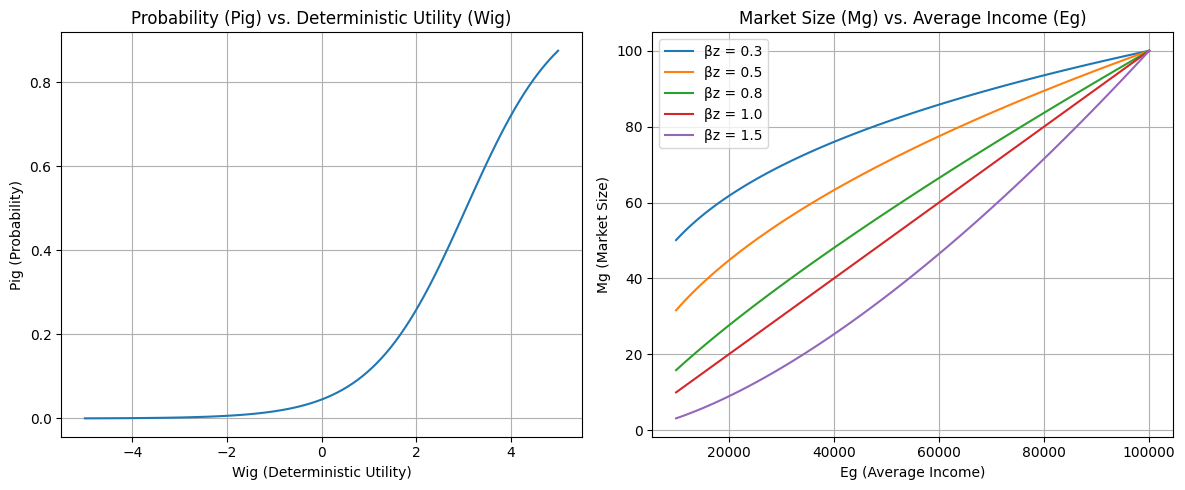

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Formulas and Term Explanations
print("Formulas:")
print("1. Probability of Choosing Facility i (Pig):")
print("   Pig = e^(Wig) / (1 + Σ(e^(Wig)))")
print("   Where:")
print("   - Pig: Probability that a customer chooses facility i")
print("   - Wig: Deterministic utility of facility i")
print("   - Σ(e^(Wig)): Sum of exponentiated utilities of all facilities")
print()
print("2. Market Size in Grid Point g (Mg):")
print("   Mg = Cg * (Eg / Emax) ^ βz")
print("   Where:")
print("   - Mg: Market size at grid point g")
print("   - Cg: Population density at grid point g")
print("   - Eg: Average income of the population at grid point g")
print("   - Emax: Upper bound on income")
print("   - βz: Parameter common across all income ranges and grid points")

# --- Probability (Pig) vs. Deterministic Utility (Wig) ---
def calculate_pig(wig, other_wigs):
    """Calculates Pig based on Wig and other Wigs."""
    all_wigs = np.append(other_wigs, wig) # Include wig in the array of utilities
    numerator = np.exp(wig)
    denominator = np.sum(np.exp(all_wigs)) # Sum of exponentiated utilities of ALL facilities
    return numerator / denominator

wig_values = np.linspace(-5, 5, 100)  # Range of Wig values
other_wigs_values = np.array([-2, 0, 3])  # Example values for other Wigs

pig_values = [calculate_pig(w, other_wigs_values) for w in wig_values]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot
plt.plot(wig_values, pig_values)
plt.title('Probability (Pig) vs. Deterministic Utility (Wig)')
plt.xlabel('Wig (Deterministic Utility)')
plt.ylabel('Pig (Probability)')
plt.grid(True)


# --- Market Size (Mg) vs. Average Income (Eg) with different beta_z values ---
def calculate_mg(cg, eg, emax, beta_z):
    """Calculates Mg based on Cg, Eg, Emax, and beta_z."""
    return cg * (eg / emax) ** beta_z

cg_value = 100  # Example population density
eg_values = np.linspace(10000, 100000, 100)  # Range of Eg values
emax_value = 100000  # Upper bound on income
beta_z_values = [0.3, 0.5, 0.8, 1.0, 1.5]  # Different beta_z values

plt.subplot(1, 2, 2)  # Second subplot
for beta_z in beta_z_values:
    mg_values = calculate_mg(cg_value, eg_values, emax_value, beta_z)
    plt.plot(eg_values, mg_values, label=f'βz = {beta_z}')

plt.title('Market Size (Mg) vs. Average Income (Eg)')
plt.xlabel('Eg (Average Income)')
plt.ylabel('Mg (Market Size)')
plt.grid(True)
plt.legend()  # Add legend to show beta_z values

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()




Prediction Formula:
Predicted Rating = b0 + b1*feature1 + b2*feature2 + b3*feature3 + b4*price + b5*age + b6*competitors + b7*cuisine_Italian + b8*cuisine_Mexican + ... + b_n*zip_10004

Terms Explanation:
b0: Intercept (baseline rating)
b1, b2, b3: Coefficients for feature1, feature2, and feature3, respectively.
b4: Coefficient for price category.
b5: Coefficient for restaurant age.
b6: Coefficient for number of competitors.
b7, b8, ... : Coefficients for each cuisine type (one-hot encoded).
b_n... : Coefficients for each zip code (one-hot encoded).
Mean Squared Error (Linear Regression): 1.888607481142283


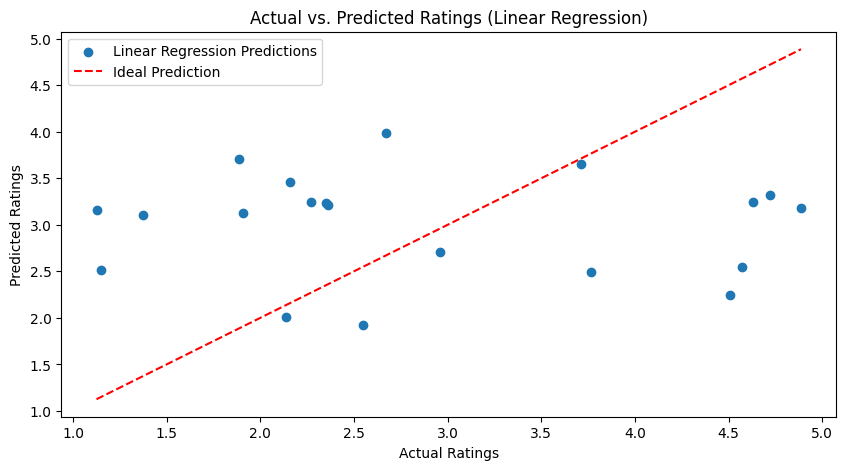


Code 2: Linear Regression with Ridge Regularization
Regularization Formula:
Minimize: (Predicted Rating - Actual Rating)^2 + lambda * (b1^2 + b2^2 + b3^2 + b4^2 + b5^2 + b6^2 + b7^2 + b8^2 + ... + bn^2)

Terms Explanation:
Predicted Rating: b0 + b1*feature1 + b2*feature2 + b3*feature3 + b4*price + b5*age + b6*competitors + b7*cuisine_Italian + b8*cuisine_Mexican + ... + b_n*zip_10004
Actual Rating: The observed rating value.
lambda: The regularization parameter (alpha in Ridge), controlling the strength of regularization.
b1, b2, b3, ... bn: Coefficients for each feature (including one-hot encoded cuisine and zip).
Mean Squared Error (Ridge Regression): 1.864537258492637


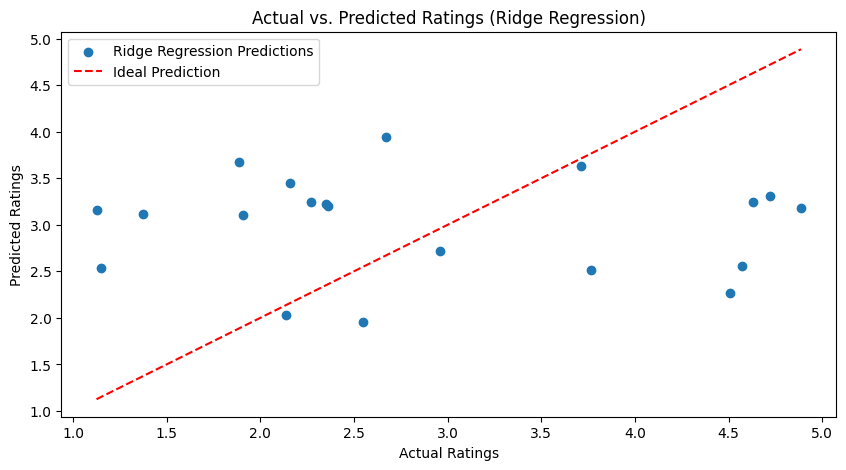


Example Data Point Where Ridge Regression Performs Better (Potentially):
             Feature     Value
0           feature1  0.028187
1           feature2  0.462006
2           feature3  1.831849
3              price         2
4                age         3
5        competitors        14
6    cuisine_Chinese      True
7    cuisine_Italian     False
8   cuisine_Japanese     False
9    cuisine_Mexican     False
10         zip_10001     False
11         zip_10002     False
12         zip_10003      True
13         zip_10004     False

Actual Rating: 4.51
Linear Regression Prediction: 2.24
Ridge Regression Prediction: 2.27


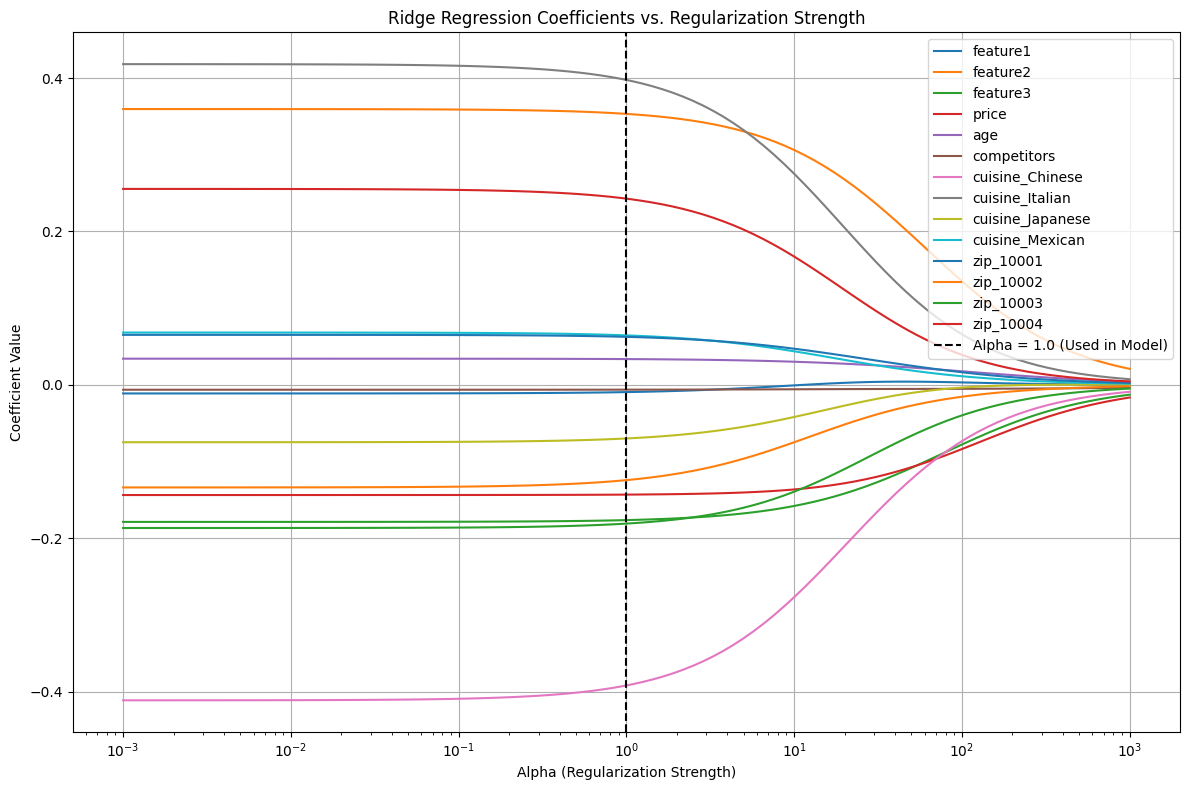

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# Code 1: Linear Regression without Regularization
class CustomLinearRegression:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        self.coef_ = np.linalg.lstsq(X, y, rcond=None)[0]
        self.intercept_ = self.coef_[0]
        self.coef_ = self.coef_[1:]

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)
        return np.dot(X, self.coef_) + self.intercept_

    def evaluate(self, y_true, y_pred):
        return mean_squared_error(y_true, y_pred)

def prepare_features(data, feature_names, cuisine_col, zip_col, price_col, age_col, competitors_col):
    cuisine_encoded = pd.get_dummies(data[cuisine_col], prefix='cuisine')
    zip_encoded = pd.get_dummies(data[zip_col], prefix='zip')
    features = pd.concat([data[feature_names], data[[price_col, age_col, competitors_col]], cuisine_encoded, zip_encoded], axis=1)
    return features.dropna()

np.random.seed(42) # For reproducibility
data = {
    'restaurant_id': range(100),
    'cuisine': np.random.choice(['Italian', 'Mexican', 'Japanese', 'Chinese'], 100),
    'zip': np.random.choice(['10001', '10002', '10003', '10004'], 100),
    'rating': np.random.uniform(1, 5, 100),
    'price': np.random.choice([1, 2, 3, 4], 100),
    'age': np.random.randint(1, 10, 100),
    'competitors': np.random.randint(0, 20, 100),
    'feature1': np.random.rand(100) + np.random.normal(0, 0.5, 100) * np.random.choice([1, 2, 3, 4], 100), # Introduce some correlation with price
    'feature2': np.random.rand(100) + np.random.normal(0, 0.5, 100) * pd.Series(np.random.choice(['10001', '10002', '10003', '10004'], 100)).astype('category').cat.codes, # Introduce some correlation with zip
    'feature3': np.random.rand(100) + np.random.normal(0, 0.5, 100) * pd.Series(np.random.choice(['Italian', 'Mexican', 'Japanese', 'Chinese'], 100)).astype('category').cat.codes, # Introduce some correlation with cuisine
}
restaurant_data = pd.DataFrame(data)
feature_names = ['feature1', 'feature2', 'feature3']

features = prepare_features(restaurant_data, feature_names, 'cuisine', 'zip', 'price', 'age', 'competitors')
ratings = restaurant_data['rating'].loc[features.index]

train_features, test_features, train_ratings, test_ratings = train_test_split(features, ratings, test_size=0.2, random_state=42)

model = CustomLinearRegression()
model.fit(train_features, train_ratings)
predictions = model.predict(test_features)
mse = model.evaluate(test_ratings, predictions)

# Formula and Terms Explanation:
print("\nPrediction Formula:")
print("Predicted Rating = b0 + b1*feature1 + b2*feature2 + b3*feature3 + b4*price + b5*age + b6*competitors + b7*cuisine_Italian + b8*cuisine_Mexican + ... + b_n*zip_10004")
print("\nTerms Explanation:")
print("b0: Intercept (baseline rating)")
print("b1, b2, b3: Coefficients for feature1, feature2, and feature3, respectively.")
print("b4: Coefficient for price category.")
print("b5: Coefficient for restaurant age.")
print("b6: Coefficient for number of competitors.")
print("b7, b8, ... : Coefficients for each cuisine type (one-hot encoded).")
print("b_n... : Coefficients for each zip code (one-hot encoded).")
print(f"Mean Squared Error (Linear Regression): {mse}")

plt.figure(figsize=(10, 5))
plt.scatter(test_ratings, predictions, label='Linear Regression Predictions')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs. Predicted Ratings (Linear Regression)")
plt.plot([min(test_ratings), max(test_ratings)], [min(test_ratings), max(test_ratings)], color='red', linestyle='--', label='Ideal Prediction')
plt.legend()
plt.show()

# Code 2: Linear Regression with Ridge Regularization
class RidgeRegressionModel:
    def __init__(self, regularization=0.1):
        self.model = Ridge(alpha=regularization)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, y_true, y_pred):
        return mean_squared_error(y_true, y_pred)

model_ridge = RidgeRegressionModel(regularization=1.0) # Increased regularization strength
model_ridge.fit(train_features, train_ratings)
predictions_ridge = model_ridge.predict(test_features)
mse_ridge = model_ridge.evaluate(test_ratings, predictions_ridge)

print("\nCode 2: Linear Regression with Ridge Regularization")
print("Regularization Formula:")
print("Minimize: (Predicted Rating - Actual Rating)^2 + lambda * (b1^2 + b2^2 + b3^2 + b4^2 + b5^2 + b6^2 + b7^2 + b8^2 + ... + bn^2)")
print("\nTerms Explanation:")
print("Predicted Rating: b0 + b1*feature1 + b2*feature2 + b3*feature3 + b4*price + b5*age + b6*competitors + b7*cuisine_Italian + b8*cuisine_Mexican + ... + b_n*zip_10004")
print("Actual Rating: The observed rating value.")
print("lambda: The regularization parameter (alpha in Ridge), controlling the strength of regularization.")
print("b1, b2, b3, ... bn: Coefficients for each feature (including one-hot encoded cuisine and zip).")
print(f"Mean Squared Error (Ridge Regression): {mse_ridge}")
plt.figure(figsize=(10, 5))
plt.scatter(test_ratings, predictions_ridge, label='Ridge Regression Predictions')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs. Predicted Ratings (Ridge Regression)")
plt.plot([min(test_ratings), max(test_ratings)], [min(test_ratings), max(test_ratings)], color='red', linestyle='--', label='Ideal Prediction')
plt.legend()
plt.show()

# Example Table - Finding a case where Ridge might perform better
comparison_df = pd.DataFrame({'actual': test_ratings, 'linear': predictions, 'ridge': predictions_ridge})
best_ridge_example = comparison_df.loc[np.abs(comparison_df['actual'] - comparison_df['ridge']) < np.abs(comparison_df['actual'] - comparison_df['linear'])].head(1)

if not best_ridge_example.empty:
    example_actual_rating = best_ridge_example['actual'].iloc[0]
    linear_prediction_example = best_ridge_example['linear'].iloc[0]
    ridge_prediction_example = best_ridge_example['ridge'].iloc[0]
    example_data_index = best_ridge_example.index[0]
    example_data = test_features.loc[example_data_index]

    example_values = pd.DataFrame({'Feature': example_data.index, 'Value': example_data.values})
    print("\nExample Data Point Where Ridge Regression Performs Better (Potentially):")
    print(example_values)
    print(f"\nActual Rating: {example_actual_rating:.2f}")
    print(f"Linear Regression Prediction: {linear_prediction_example:.2f}")
    print(f"Ridge Regression Prediction: {ridge_prediction_example:.2f}")
else:
    print("\nCould not find a clear example where Ridge Regression's prediction is noticeably better than Linear Regression's for a single data point with the current data generation.")

# Ridge Coefficient Graph
alphas = np.logspace(-3, 3, 100)
ridge_coefs = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(train_features, train_ratings)
    ridge_coefs.append(ridge.coef_)

ridge_coef_df = pd.DataFrame(ridge_coefs, index=alphas, columns=train_features.columns)

plt.figure(figsize=(12, 8))
for column in ridge_coef_df.columns:
    plt.plot(ridge_coef_df.index, ridge_coef_df[column], label=column)
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regression Coefficients vs. Regularization Strength')
plt.axvline(x=1.0, color='black', linestyle='--', label=f'Alpha = {1.0} (Used in Model)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()